In [2]:
%matplotlib inline

import irtk
import numpy as np
from glob import glob
import os
import scipy.ndimage as nd
from skimage import morphology

import cPickle as pickle

import matplotlib
#matplotlib.use('cairo')
import matplotlib.pyplot as plt

import csv

# http://nbviewer.ipython.org/github/mwaskom/seaborn/blob/master/examples/plotting_distributions.ipynb
import pandas as pd
import seaborn as sns

# scale font size
sns.set(font_scale=1.8)

from sklearn.cluster import MeanShift, KMeans

from joblib import Parallel, delayed

import base64
import skimage.io

from IPython.display import display

import sys
sys.path.append("../lib")
sys.path.append("../../commonlib")
from libdetector import *
from commonlibdetector import *
from fetal_anatomy import *

hastie_orange = (0.906,0.624,0)
hastie_blue = (0.337,0.706,0.914)
hastie_red = (0.678,0.137,0.137)
hastie_green = (0.114,0.412,0.078)

ground_truth_labels = [ "body",
                        "brain",
                        "left_lung",
                        "right_lung",
                        "heart",
                        "left_kidney",
                        "right_kidney",
                        "liver",
                        "face" ]

for i in range(len(ground_truth_labels)):
    print i+1, ground_truth_labels[i]
    
all_ga = {}
reader = csv.reader( open( "/vol/medic02/users/kpk09/Melissa_reconstructions/melissa_ga.tsv", "rb"), delimiter="\t" )
for patient_id, ga in reader:
    all_ga[patient_id] = float(ga)

1 body
2 brain
3 left_lung
4 right_lung
5 heart
6 left_kidney
7 right_kidney
8 liver
9 face


:0: FutureWarning: IPython widgets are experimental and may change in the future.


Motion free data
----------------

In [3]:
def score_one_patient( detection_folder1,
                       detection_folder2,
                       ground_truth_folder,
                       patient_id,
                       all_ga,
                       all_iugr ):
    
    labels = irtk.imread( ground_truth_folder + "/" + patient_id + "_seg.nii.gz")
    
    # first stage
    res_heart = irtk.imread( detection_folder1 + "/" + patient_id+"/votes_blurred_heart.nii.gz" )
                
    center_heart =  labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),dtype='float32')[::-1])
        
    first_heart = res_heart.ImageToWorld(np.unravel_index(np.argmax(res_heart), res_heart.shape ))
    
  
    # second stage
    landmarks = irtk.imread( detection_folder2 + "/" + patient_id+"/landmarks.nii.gz" )
    
    if landmarks is None:
        print "something wrong for patient",patient_id
        return [int(patient_id), 100, 100, 100, 100, 100]

    center_left_lung =  labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 3).view(np.ndarray) ),dtype='float32')[::-1])
    detected_left_lung = landmarks.ImageToWorld(np.array(nd.center_of_mass( (landmarks == 1).view(np.ndarray) ),dtype='float32')[::-1])
    
    center_right_lung =  labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 4).view(np.ndarray) ),dtype='float32')[::-1])
    detected_right_lung = landmarks.ImageToWorld(np.array(nd.center_of_mass( (landmarks == 2).view(np.ndarray) ),dtype='float32')[::-1])
    
    center_heart =  labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),dtype='float32')[::-1])
    detected_heart = landmarks.ImageToWorld(np.array(nd.center_of_mass( (landmarks == 3).view(np.ndarray) ),dtype='float32')[::-1])
    
    center_liver =  labels.ImageToWorld(np.array(nd.center_of_mass( (labels == 8).view(np.ndarray) ),dtype='float32')[::-1])
    detected_liver = landmarks.ImageToWorld(np.array(nd.center_of_mass( (landmarks == 4).view(np.ndarray) ),dtype='float32')[::-1])
      
    error_first = np.linalg.norm( center_heart - first_heart )
        
    error_left_lung = min(np.linalg.norm( center_left_lung - detected_left_lung ),100)
    error_right_lung = min(np.linalg.norm( center_right_lung - detected_right_lung ),100)
    error_heart = min(np.linalg.norm( center_heart - detected_heart ),100)
    error_liver = min(np.linalg.norm( center_liver - detected_liver ),100)

    return [int(patient_id), error_first, error_left_lung, error_right_lung, error_heart, error_liver,
            all_ga[patient_id],all_iugr[patient_id][0]==1]

def score_all( detection_folder1,
               detection_folder2,
               ground_truth_folder,
               n_jobs=10 ):
        
    all_files = sorted( glob( detection_folder1+"/*/img.nii.gz" ) )
    
    all_patients = []
    for f in all_files:
        all_patients.append( f.split('/')[-2] )
        
    all_ga = {}
    reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/melissa_ga.tsv", "rb"), delimiter="\t" )
    for patient_id, ga in reader:
        all_ga[patient_id] = float(ga)
    
    all_iugr = {}
    reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/iugr.tsv", "rb"), delimiter="\t" )
    skip = True
    for patient_id, iugr, iugr_severity in reader:
        if skip:
            skip = False
            continue
        all_iugr[patient_id] = (int(iugr), int(iugr_severity))
        
    scores = Parallel(n_jobs=n_jobs)(delayed(score_one_patient)( detection_folder1,
                                                                 detection_folder2,
                                                                 ground_truth_folder,
                                                                 patient_id,
                                                                 all_ga,
                                                                 all_iugr )
                                               for patient_id in all_patients )
        
    scores = np.array(scores)
    
    return pd.DataFrame( { 'patient_id' : scores[:,0],
                           'first_error' : scores[:,1],
                           'Left lung' : scores[:,2],
                           'Right lung' : scores[:,3],
                           'Heart' : scores[:,4],
                           'Liver' : scores[:,5],
                           'ga' : scores[:,6],
                           'IUGR' : scores[:,7] } ).convert_objects(convert_numeric=True)

In [4]:
def count_inside_one_patient( detection_folder,
                              ground_truth_folder,
                              patient_id,
                              all_ga,
                              all_iugr,
                              padding ):
    
    labels = irtk.imread( ground_truth_folder + "/" + patient_id + "_seg.nii.gz")
    seg = irtk.imread( detection_folder + "/" + patient_id+"/final_seg.nii.gz" )
    landmarks = irtk.imread( detection_folder + "/" + patient_id+"/landmarks.nii.gz" )
    
    inside_left_lung = float(np.sum( labels[seg==1] == 3 )) / float(np.sum(seg==1))
    inside_right_lung = float(np.sum( labels[seg==2] == 4 )) / float(np.sum(seg==2))
    inside_heart = float(np.sum( labels[seg==3] == 5 )) / float(np.sum(seg==3))
    inside_liver = float(np.sum( labels[seg==4] == 8 )) / float(np.sum(seg==4))
    
    detected_left_lung = np.array(nd.center_of_mass( (landmarks == 1).view(np.ndarray) ),dtype='float32') - padding
    detected_right_lung = np.array(nd.center_of_mass( (landmarks == 2).view(np.ndarray) ),dtype='float32') - padding
    detected_heart = np.array(nd.center_of_mass( (landmarks == 3).view(np.ndarray) ),dtype='float32') - padding
    detected_liver = np.array(nd.center_of_mass( (landmarks == 4).view(np.ndarray) ),dtype='float32') - padding
      
    center_left_lung = labels[detected_left_lung[0],
                              detected_left_lung[1],
                              detected_left_lung[2]] == 3
    center_right_lung = labels[detected_right_lung[0],
                               detected_right_lung[1],
                               detected_right_lung[2]] == 4
    center_heart = labels[detected_heart[0],
                          detected_heart[1],
                          detected_heart[2]] == 5
    center_liver = labels[detected_liver[0],
                          detected_liver[1],
                          detected_liver[2]] == 8
    
    return [int(patient_id), 
            inside_left_lung, inside_right_lung, inside_heart, inside_liver,
            center_left_lung, center_right_lung, center_heart, center_liver,
            center_left_lung and center_right_lung and center_heart and center_liver,
            all_ga[patient_id],all_iugr[patient_id][0]==1]

def count_inside_all( detection_folder,
                      ground_truth_folder,
                      n_jobs=10,
                      padding=0 ):
        
    all_files = sorted( glob( detection_folder+"/*/img.nii.gz" ) )
    
    all_patients = []
    for f in all_files:
        all_patients.append( f.split('/')[-2] )
        
    all_ga = {}
    reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/melissa_ga.tsv", "rb"), delimiter="\t" )
    for patient_id, ga in reader:
        all_ga[patient_id] = float(ga)
    
    all_iugr = {}
    reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/iugr.tsv", "rb"), delimiter="\t" )
    skip = True
    for patient_id, iugr, iugr_severity in reader:
        if skip:
            skip = False
            continue
        all_iugr[patient_id] = (int(iugr), int(iugr_severity))

    scores = Parallel(n_jobs=n_jobs)(delayed(count_inside_one_patient)( detection_folder,
                                                                 ground_truth_folder,
                                                                 patient_id,
                                                                 all_ga,
                                                                 all_iugr,
                                                                 padding )
                                               for patient_id in all_patients )
        
    scores = np.array(scores)
    
    return pd.DataFrame( { 'patient_id' : scores[:,0],
                           'Left lung' : scores[:,1]*100,
                           'Right lung' : scores[:,2]*100,
                           'Heart' : scores[:,3]*100,
                           'Liver' : scores[:,4]*100,
                           'Center left lung' : scores[:,5],
                           'Center right lung' : scores[:,6],
                           'Center heart' : scores[:,7],
                           'Center liver' : scores[:,8],
                           'All in' : scores[:,9],
                           'ga' : scores[:,10],
                           'IUGR' : scores[:,11] } ).convert_objects(convert_numeric=True)

In [5]:
def get_ellipsoids( f, scale=1.96 ):
    seg = irtk.imread( f )
    
    heart =  np.argwhere( (seg == 5).view(np.ndarray) ).astype('float32')
    left_lung =  np.argwhere( (seg == 3).view(np.ndarray) ).astype('float32')
    right_lung = np.argwhere( (seg == 4).view(np.ndarray) ).astype('float32')
    liver = np.argwhere( (seg == 8).view(np.ndarray) ).astype('float32')

    mean_heart = np.mean( heart, axis=0 )
    mean_left_lung = np.mean( left_lung, axis=0 )
    mean_right_lung = np.mean( right_lung, axis=0 )
    mean_liver = np.mean( liver, axis=0 )

    cov_heart = np.cov( heart.T )*scale**2
    cov_left_lung = np.cov( left_lung.T )*scale**2
    cov_right_lung = np.cov( right_lung.T  )*scale**2
    cov_liver = np.cov( liver.T )*scale**2

    return [ mean_heart, mean_left_lung, mean_right_lung, mean_liver, 
             cov_heart, cov_left_lung, cov_right_lung, cov_liver ]

def is_in_ellipsoid( p, mean, cov ):
    inv_cov = np.linalg.pinv( cov )
    return np.dot( np.transpose(p-mean),np.dot(inv_cov,p-mean) ) < 1

def count_inside_ellipsoid_one_patient( detection_folder,
                              ground_truth_folder,
                              patient_id,
                              all_ga,
                              all_iugr,
                              padding,
                              scale,
                              debug):
    
    f_labels = ground_truth_folder + "/" + patient_id + "_seg.nii.gz"
    if debug:
        debug_ellipsoid( f_labels, scale )
    
    ( mean_heart, mean_left_lung, mean_right_lung, mean_liver, 
      cov_heart, cov_left_lung, cov_right_lung, cov_liver ) = get_ellipsoids( f_labels, scale=scale )
    
    landmarks = irtk.imread( detection_folder + "/" + patient_id+"/landmarks.nii.gz" )
    
    detected_left_lung = np.array(nd.center_of_mass( (landmarks == 1).view(np.ndarray) ),dtype='float32') - padding
    detected_right_lung = np.array(nd.center_of_mass( (landmarks == 2).view(np.ndarray) ),dtype='float32') - padding
    detected_heart = np.array(nd.center_of_mass( (landmarks == 3).view(np.ndarray) ),dtype='float32') - padding
    detected_liver = np.array(nd.center_of_mass( (landmarks == 4).view(np.ndarray) ),dtype='float32') - padding
      
    inside_left_lung = is_in_ellipsoid( detected_left_lung, mean_left_lung, cov_left_lung )
    inside_right_lung = is_in_ellipsoid( detected_right_lung, mean_right_lung, cov_right_lung )
    inside_heart = is_in_ellipsoid( detected_heart, mean_heart, cov_heart )
    inside_liver = is_in_ellipsoid( detected_liver, mean_liver, cov_liver )
    
    return [int(patient_id), 
            inside_left_lung, inside_right_lung, inside_heart, inside_liver,
            inside_left_lung and inside_right_lung and inside_heart and inside_liver,
            all_ga[patient_id],all_iugr[patient_id][0]==1]

def debug_ellipsoid( f, scale ):
    ( mean_heart, mean_left_lung, mean_right_lung, mean_liver, 
      cov_heart, cov_left_lung, cov_right_lung, cov_liver ) = get_ellipsoids( f, scale=scale )
    labels = irtk.imread(f)
    res = irtk.zeros( labels.get_header(), dtype='uint8' )
    points = np.argwhere( res == 0 )
    for i, (mean, cov) in enumerate(zip( [mean_heart, mean_left_lung, mean_right_lung, mean_liver], 
                                       [cov_heart, cov_left_lung, cov_right_lung, cov_liver] ),
                                  start=1):
        inv_cov = np.linalg.pinv(cov)
        selection = np.sum( np.dot(points-mean, inv_cov) * (points-mean), 1) < 1
        pts = points[selection]
        res[pts[:,0],
            pts[:,1],
            pts[:,2]] = i
        
    irtk.imwrite( "tmp/debug_ellipsoids/"+os.path.basename(f), res )
    return 

def count_inside_ellipsoid( detection_folder,
                      ground_truth_folder,
                      n_jobs=10,
                      padding=0,
                      scale=1.0,
                      debug=False):
        
    all_files = sorted( glob( detection_folder+"/*/img.nii.gz" ) )
    
    all_patients = []
    for f in all_files:
        all_patients.append( f.split('/')[-2] )
        
    all_ga = {}
    reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/melissa_ga.tsv", "rb"), delimiter="\t" )
    for patient_id, ga in reader:
        all_ga[patient_id] = float(ga)
    
    all_iugr = {}
    reader = csv.reader( open( "/vol/vipdata/data/fetal_data/Mellisa_Damodaram/iugr.tsv", "rb"), delimiter="\t" )
    skip = True
    for patient_id, iugr, iugr_severity in reader:
        if skip:
            skip = False
            continue
        all_iugr[patient_id] = (int(iugr), int(iugr_severity))

    scores = Parallel(n_jobs=n_jobs)(delayed(count_inside_ellipsoid_one_patient)( detection_folder,
                                                                 ground_truth_folder,
                                                                 patient_id,
                                                                 all_ga,
                                                                 all_iugr,
                                                                 padding,
                                                                 scale=scale,
                                                                 debug=debug)
                                               for patient_id in all_patients )
        
    scores = np.array(scores)
    
    return pd.DataFrame( { 'patient_id' : scores[:,0],
                           'Left lung' : scores[:,1],
                           'Right lung' : scores[:,2],
                           'Heart' : scores[:,3],
                           'Liver' : scores[:,4],
                           'All in' : scores[:,5],
                           'ga' : scores[:,6],
                           'IUGR' : scores[:,7] } ).convert_objects(convert_numeric=True)

how many times the detected heart is within 10mm of the true heart?
0.945454545455
how many times the error for the lungs is less than 15mm
0.854545454545
how many times the error for the liver is less than 20mm
0.909090909091


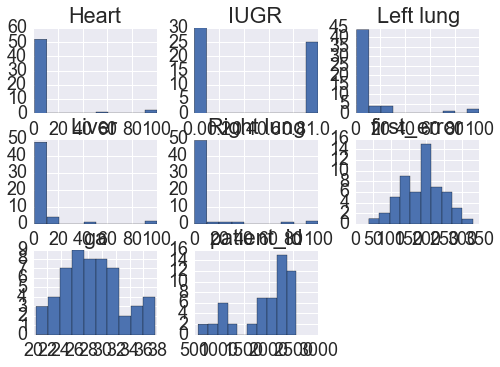

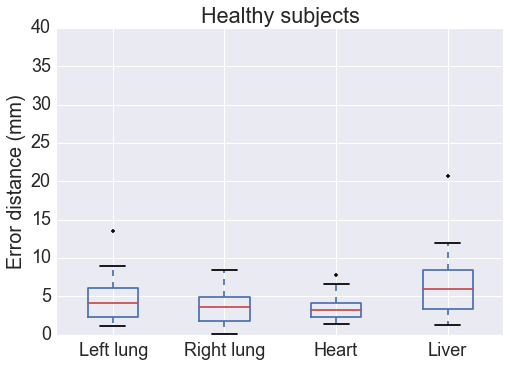

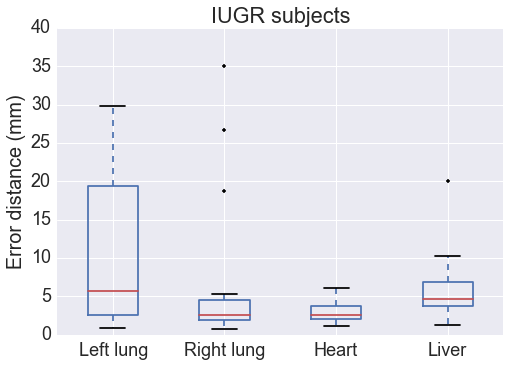

In [6]:
detection_folder1 = "/vol/vipdata/data/fetal_data/OUTPUT/stage1_shape_prediction_padding0"
detection_folder2 = "/vol/vipdata/data/fetal_data/OUTPUT/stage2_shape_prediction_padding0"
ground_truth_folder = "/vol/bitbucket/kpk09/detector/data_resampled"
data_leaveoneout = score_all(detection_folder1, detection_folder2, ground_truth_folder,n_jobs=20 )
data_leaveoneout.hist();

## Healthy
plt.figure()
ax = data_leaveoneout[data_leaveoneout['IUGR']==0][["Left lung","Right lung","Heart","Liver"]].boxplot(return_type='axes',
                                                                               flierprops={'marker':'.','color':[0,0,0]},
                                                                               fontsize=18 );

ax.set_ylim([0,40])
ax.yaxis.set_ticks(np.arange(0, 41, 5))
ax.set_ylabel("Error distance (mm)")
ax.set_title('Healthy subjects');
plt.savefig("error_distance_healthy.pdf", bbox_inches="tight");

## IUGR
plt.figure()
ax = data_leaveoneout[data_leaveoneout['IUGR']==1][["Left lung","Right lung","Heart","Liver"]].boxplot(return_type='axes',
                                                                               flierprops={'marker':'.','color':[0,0,0]},
                                                                               fontsize=18 );
ax.set_ylim([0,40])
ax.yaxis.set_ticks(np.arange(0, 41, 5))
ax.set_ylabel("Error distance (mm)")
ax.set_title('IUGR subjects');
plt.savefig("error_distance_iugr.pdf", bbox_inches="tight");

print "how many times the detected heart is within 10mm of the true heart?"
print float(np.sum(data_leaveoneout['Heart'] <= 10))/len(data_leaveoneout.index)

print "how many times the error for the lungs is less than 15mm"
print float(np.sum(np.logical_and(data_leaveoneout['Left lung'] <= 15,
                            data_leaveoneout['Right lung'] <= 15)))/len(data_leaveoneout.index)

print "how many times the error for the liver is less than 20mm"
print float(np.sum(data_leaveoneout['Liver'] <= 20))/len(data_leaveoneout.index)

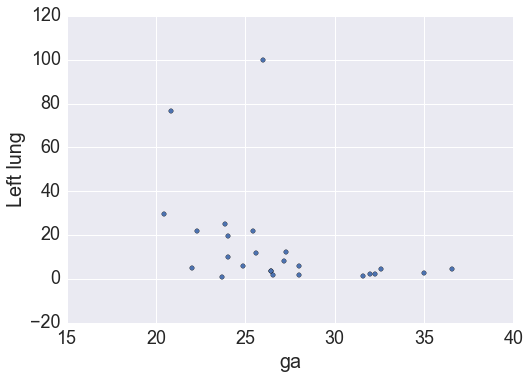

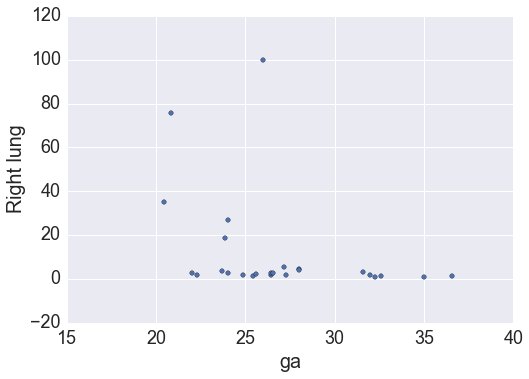

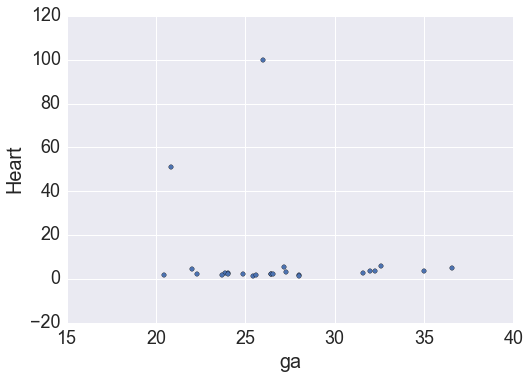

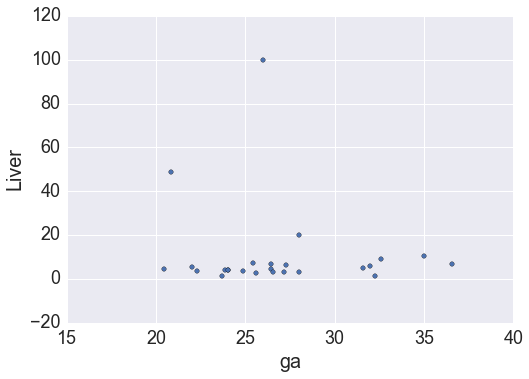

In [32]:
for col in ['Left lung','Right lung','Heart','Liver']:
    plt.figure()
    data_leaveoneout[data_leaveoneout['IUGR']==1].plot(x='ga',y=col,kind='scatter');

Healthy subjects
Center left lung [ 5 25] [ 16.66666667  83.33333333]
Center right lung [ 1 29] [  3.33333333  96.66666667]
Center heart [ 2 28] [  6.66666667  93.33333333]
Center liver [ 4 26] [ 13.33333333  86.66666667]
All in: 73.3333333333
IUGR subjects
Center left lung [10 15] [ 40.  60.]
Center right lung [ 5 20] [ 20.  80.]
Center heart [ 3 22] [ 12.  88.]
Center liver [ 5 20] [ 20.  80.]
All in: 52.0


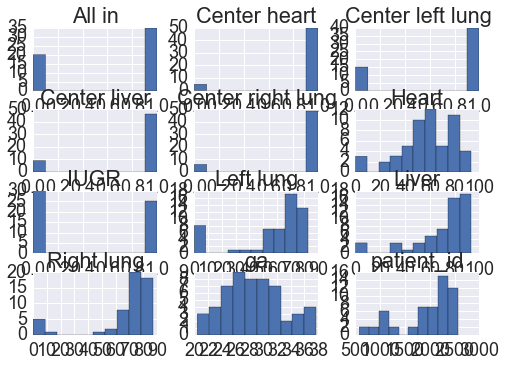

In [14]:
detection_folder = "/vol/vipdata/data/fetal_data/OUTPUT/stage2_shape_prediction_padding0"
ground_truth_folder = "/vol/bitbucket/kpk09/detector/data_resampled"
data_leaveoneout_count = count_inside_all(detection_folder, ground_truth_folder,n_jobs=20, padding=0 )
data_leaveoneout_count.hist();

print "Healthy subjects"
for cl in ["Center left lung","Center right lung","Center heart","Center liver"]:
    binning = np.bincount(data_leaveoneout_count[data_leaveoneout_count['IUGR']==0][cl].astype('int32'),minlength=2)
    print cl, binning, binning.astype('float') / 30 * 100
    
print "All in:", data_leaveoneout_count[data_leaveoneout_count['IUGR']==0]['All in'].sum() / 30 * 100
    
print "IUGR subjects"
for cl in ["Center left lung","Center right lung","Center heart","Center liver"]:
    binning = np.bincount(data_leaveoneout_count[data_leaveoneout_count['IUGR']==1][cl].astype('int32'),minlength=2)
    print cl, binning, binning.astype('float') / 25 * 100
    
print "All in:", data_leaveoneout_count[data_leaveoneout_count['IUGR']==1]['All in'].sum() / 25 * 100

All in            38.00
Heart             50.00
IUGR              25.00
Left lung         44.00
Liver             46.00
Right lung        49.00
ga              1575.12
patient_id    107025.00
dtype: float64
Healthy subjects
Left lung [ 1 29] [  3.33333333  96.66666667]
Right lung [ 1 29] [  3.33333333  96.66666667]
Heart [ 3 27] [ 10.  90.]
Liver [ 3 27] [ 10.  90.]
IUGR subjects
Left lung [10 15] [ 40.  60.]
Right lung [ 5 20] [ 20.  80.]
Heart [ 2 23] [  8.  92.]
Liver [ 6 19] [ 24.  76.]


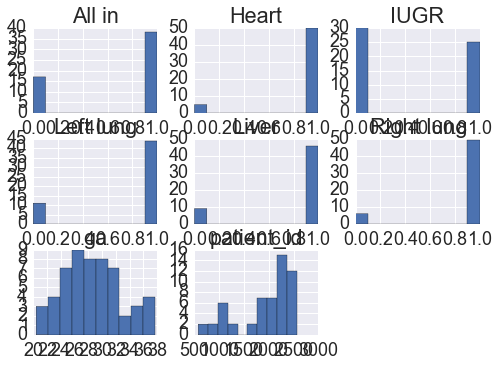

In [15]:
detection_folder2 = "/vol/vipdata/data/fetal_data/OUTPUT/stage2_shape_prediction_padding0"
ground_truth_folder = "/vol/bitbucket/kpk09/detector/data_resampled"
data_leaveoneout_ellipsoid = count_inside_ellipsoid( detection_folder2, ground_truth_folder,n_jobs=20, 
                                          scale=1.0,padding=0, debug=False )
plt.rc('text', usetex=False)
data_leaveoneout_ellipsoid.hist();
print data_leaveoneout_ellipsoid.sum()

print "Healthy subjects"
for cl in ["Left lung","Right lung","Heart","Liver"]:
    binning = np.bincount(data_leaveoneout_ellipsoid[data_leaveoneout_ellipsoid['IUGR']==0][cl].astype('int32'),minlength=2)
    print cl, binning, binning.astype('float') / 30 * 100
    
print "IUGR subjects"
for cl in ["Left lung","Right lung","Heart","Liver"]:
    binning = np.bincount(data_leaveoneout_ellipsoid[data_leaveoneout_ellipsoid['IUGR']==1][cl].astype('int32'),minlength=2)
    print cl, binning, binning.astype('float') / 25 * 100

Additional experiments
---------------------------

how many times the detected heart is within 10mm of the true heart?
0.872727272727
how many times the error for the lungs is less than 15mm
0.818181818182
how many times the error for the liver is less than 20mm
0.872727272727


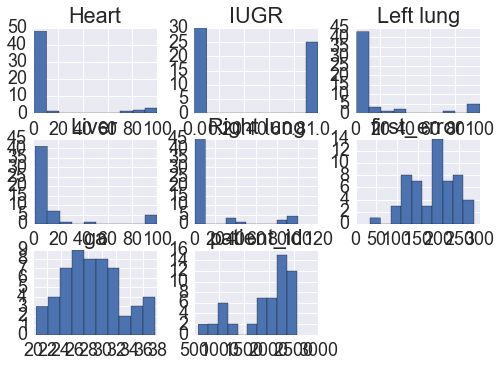

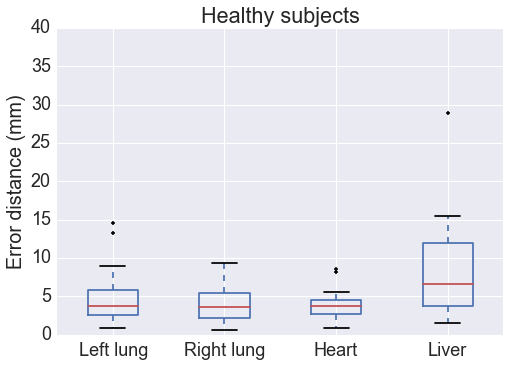

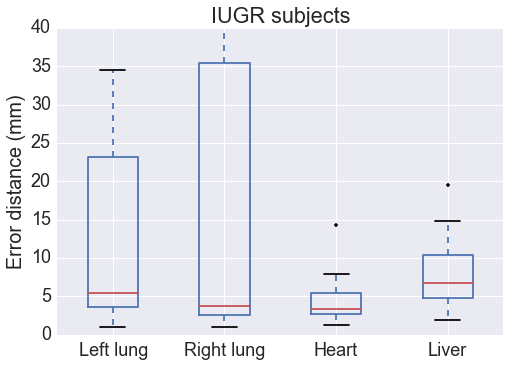

In [5]:
detection_folder1 = "/vol/vipdata/data/fetal_data/OUTPUT/stage1_fast_predicton" # missing i
detection_folder2 = "/vol/vipdata/data/fetal_data/OUTPUT/stage2_fast_prediction"
ground_truth_folder = "/vol/bitbucket/kpk09/detector/data_resampled"
data_leaveoneout = score_all(detection_folder1, detection_folder2, ground_truth_folder,n_jobs=20 )
data_leaveoneout.hist();

## Healthy
plt.figure()
ax = data_leaveoneout[data_leaveoneout['IUGR']==0][["Left lung","Right lung","Heart","Liver"]].boxplot(return_type='axes',
                                                                               flierprops={'marker':'.','color':[0,0,0]},
                                                                               fontsize=18 );

ax.set_ylim([0,40])
ax.yaxis.set_ticks(np.arange(0, 41, 5))
ax.set_ylabel("Error distance (mm)")
ax.set_title('Healthy subjects');
plt.savefig("error_distance_healthy_fast.pdf", bbox_inches="tight");

## IUGR
plt.figure()
ax = data_leaveoneout[data_leaveoneout['IUGR']==1][["Left lung","Right lung","Heart","Liver"]].boxplot(return_type='axes',
                                                                               flierprops={'marker':'.','color':[0,0,0]},
                                                                               fontsize=18 );
ax.set_ylim([0,40])
ax.yaxis.set_ticks(np.arange(0, 41, 5))
ax.set_ylabel("Error distance (mm)")
ax.set_title('IUGR subjects');
plt.savefig("error_distance_iugr_fast.pdf", bbox_inches="tight");

print "how many times the detected heart is within 10mm of the true heart?"
print float(np.sum(data_leaveoneout['Heart'] <= 10))/len(data_leaveoneout.index)

print "how many times the error for the lungs is less than 15mm"
print float(np.sum(np.logical_and(data_leaveoneout['Left lung'] <= 15,
                            data_leaveoneout['Right lung'] <= 15)))/len(data_leaveoneout.index)

print "how many times the error for the liver is less than 20mm"
print float(np.sum(data_leaveoneout['Liver'] <= 20))/len(data_leaveoneout.index)

Motion corrupted dataset:
----------------------------

In [7]:
def score_one_patient2( detection_folder,
                        ground_truth_folder,
                        f,
                        brain_ground_truth ):
    
    patient_id = os.path.basename(f)
    ground_truth_file = ground_truth_folder + "/" + patient_id + "_landmarks.nii.gz"
    
    if not os.path.exists(ground_truth_file):
        print "missing ground thruth", ground_truth_file
        return [np.inf, np.inf, np.inf, np.inf, np.inf,np.inf]
    
    labels = irtk.imread( ground_truth_file )
    
    # ground truth
    center_left_lung = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 1).view(np.ndarray) ),dtype='float32')[::-1])
    center_right_lung = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),dtype='float32')[::-1])
    center_heart = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 3).view(np.ndarray) ),dtype='float32')[::-1])
    center_liver = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 4).view(np.ndarray) ),dtype='float32')[::-1])
    #center_brain = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),dtype='float32')[::-1])
   
    liver_z = abs( np.array(nd.center_of_mass( (labels == 4).view(np.ndarray) ),dtype='float32')[0] -
                   labels.shape[0]/2 )
    
    if patient_id in brain_ground_truth:
        center_brain = brain_ground_truth[patient_id]
    else:
        print patient_id, "not in brainboxes.tsv"
        center_brain = labels.ImageToWorld( np.array(nd.center_of_mass( (labels == 5).view(np.ndarray) ),dtype='float32')[::-1])
        
    # brain detection
    #brain_mask = irtk.imread(f+"/brain_mask.nii.gz")
    brain_mask = f+"/brain_mask.nii.gz"
    if not os.path.exists(brain_mask):
        print "brain not found",patient_id
        return [100, 100, 100, 100, 100, liver_z]
    
    #detected_brain = brain_mask.ImageToWorld( np.array(nd.center_of_mass( (brain_mask == 1).view(np.ndarray) ),dtype='float32')[::-1])
    detected_brain = get_center_brain_detection(brain_mask)
    
    # second stage
    landmarks = irtk.imread( f + "/prediction_2/landmarks.nii.gz" )
    #landmarks = irtk.imread( f + "/prediction_2/final_seg.nii.gz" )
    
    if landmarks is None:
        print "something wrong for patient",patient_id
        return [100, 100, 100, 100, 100, liver_z]

    detected_left_lung = landmarks.ImageToWorld( np.array(nd.center_of_mass( (landmarks == 1).view(np.ndarray) ),dtype='float32')[::-1])
    
    detected_right_lung = landmarks.ImageToWorld( np.array(nd.center_of_mass( (landmarks == 2).view(np.ndarray) ),dtype='float32')[::-1])

    detected_heart = landmarks.ImageToWorld( np.array(nd.center_of_mass( (landmarks == 3).view(np.ndarray) ),dtype='float32')[::-1])
    
    detected_liver = landmarks.ImageToWorld( np.array(nd.center_of_mass( (landmarks == 4).view(np.ndarray) ),dtype='float32')[::-1])
        
    error_left_lung = np.linalg.norm( center_left_lung - detected_left_lung )
    error_right_lung = np.linalg.norm( center_right_lung - detected_right_lung )
    error_heart = np.linalg.norm( center_heart - detected_heart )
    error_liver = np.linalg.norm( center_liver - detected_liver )
    error_brain = np.linalg.norm( center_brain - detected_brain )

    return [ error_left_lung, error_right_lung, error_heart, error_liver, error_brain, liver_z ]

def score_all2( detection_folder,
               ground_truth_folder,
               n_jobs=10 ):
        
    all_folders = sorted( glob( detection_folder+"/*" ) )
        
    original_folder = "/vol/vipdata/data/fetal_data/motion_correction"
    brain_ground_truth = {}
    reader = csv.reader( open( original_folder + "/brainboxes.tsv", "rb"), delimiter="\t" )
    for patient_id, filename, sct, corner, size in reader:
        file_id = filename[:-len(".nii")]
        brain_ground_truth[file_id] = get_box_center(map(float,corner.split(',')),
                                                      map(float,size.split(',')),
                                                      original_folder+"/original_scans/"+filename)
       
    all_folders_no_thick_slices = []
    for f in all_folders:
        file_id = os.path.basename(f)
        header = irtk.imread( original_folder + '/original_scans/'+file_id+'.nii',
                              empty=True, 
                              force_neurological=False ).get_header()
        if header['pixelSize'][2] > 2.0*header['pixelSize'][0]:
            print "Thick slices:", os.path.basename(f), header['pixelSize']
        else:
            all_folders_no_thick_slices.append(f)
            
    all_folders = all_folders_no_thick_slices
        
    ga_file = "/vol/vipdata/data/fetal_data/motion_correction/ga.tsv"
    all_ga = {}
    reader = csv.reader( open( ga_file, "rb"), delimiter=" " )
    for patient_id, ga in reader:
        all_ga[patient_id] = float(ga)
        
    scores = Parallel(n_jobs=n_jobs)(delayed(score_one_patient2)( detection_folder,
                                                                  ground_truth_folder,
                                                                  f,
                                                                  brain_ground_truth )
                                               for f in all_folders )
        
    patient_id, scores = map(os.path.basename, all_folders), np.array(scores)
    return pd.DataFrame({ 'patient_id' : patient_id,
                          'Left lung' : scores[:,0],
                          'Right lung' : scores[:,1],
                          'Heart' : scores[:,2],
                          'Liver' : scores[:,3],
                          'Brain' : scores[:,4],
                          'liver_z' : scores[:,5],
                          'ga' : map( lambda x: all_ga[x.split('_')[0]], patient_id )})

In [8]:
def count_inside_ellipsoid_one_patient_motion( f,
                              ground_truth_folder,
                              padding,
                              scale,
                              debug):
    
    patient_id = os.path.basename(f)
    f_labels = ground_truth_folder + "/" + patient_id + "_landmarks.nii.gz"
    f_img = f + "/prediction_2/img.nii.gz"
    
    f_shape_model = "/vol/medic02/users/kpk09/OUTPUT/stage1_shape/2379/shape_model.pk"
    shape_model = pickle.load( open( f_shape_model, 'rb' ) )
    
    if debug:
        debug_ellipsoid_motion( f_labels, shape_model, scale )
        
    labels = irtk.imread(f_labels)
    img = irtk.imread( f_img )
    labels = labels.transform( target=img, interpolation='nearest' )        
        
    u,v,w = get_orientation_motion(labels)
    M = np.array( [w,v,u], dtype='float32' )
    
    mean_heart = np.array(nd.center_of_mass( (labels == 3).view(np.ndarray) ),dtype='float32')
    mean_left_lung = np.array(nd.center_of_mass( (labels == 1).view(np.ndarray) ),dtype='float32')
    mean_right_lung = np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),dtype='float32')
    mean_liver = np.array(nd.center_of_mass( (labels == 4).view(np.ndarray) ),dtype='float32')
    
    cov_heart = shape_model['cov_heart']*scale**2
    cov_left_lung = shape_model['cov_left_lung']*scale**2
    cov_right_lung = shape_model['cov_right_lung']*scale**2
    cov_liver = shape_model['cov_liver']*scale**2
    
    landmarks = irtk.imread( f + "/prediction_2/landmarks.nii.gz" )
    
    if landmarks is None:
        print "something wrong for patient",patient_id
        return [0,0,0,0,0]
    
    detected_left_lung = np.array(nd.center_of_mass( (landmarks == 1).view(np.ndarray) ),dtype='float32') - padding
    detected_right_lung = np.array(nd.center_of_mass( (landmarks == 2).view(np.ndarray) ),dtype='float32') - padding
    detected_heart = np.array(nd.center_of_mass( (landmarks == 3).view(np.ndarray) ),dtype='float32') - padding
    detected_liver = np.array(nd.center_of_mass( (landmarks == 4).view(np.ndarray) ),dtype='float32') - padding
      
    inside_left_lung = is_in_ellipsoid_motion( detected_left_lung, mean_left_lung, cov_left_lung, (u,v,w), mean_heart )
    inside_right_lung = is_in_ellipsoid_motion( detected_right_lung, mean_right_lung, cov_right_lung, (u,v,w), mean_heart )
    inside_heart = is_in_ellipsoid_motion( detected_heart, mean_heart, cov_heart, (u,v,w), mean_heart )
    inside_liver = is_in_ellipsoid_motion( detected_liver, mean_liver, cov_liver, (u,v,w), mean_heart )
    
    return [inside_left_lung, inside_right_lung, inside_heart, inside_liver,
            inside_left_lung and inside_right_lung and inside_heart and inside_liver]

def debug_ellipsoid_motion( f_labels, f_img, shape_model, scale ):
    labels = irtk.imread(f_labels)
    img = irtk.imread(f_img)
    labels = labels.transform( target=img, interpolation='nearest' ) 
    
    u,v,w = get_orientation_motion(labels)
    M = np.array( [w,v,u], dtype='float32' )
    
    mean_heart = np.array(nd.center_of_mass( (labels == 3).view(np.ndarray) ),dtype='float32')
    mean_left_lung = np.array(nd.center_of_mass( (labels == 1).view(np.ndarray) ),dtype='float32')
    mean_right_lung = np.array(nd.center_of_mass( (labels == 2).view(np.ndarray) ),dtype='float32')
    mean_liver = np.array(nd.center_of_mass( (labels == 4).view(np.ndarray) ),dtype='float32')
    
    cov_heart = shape_model['cov_heart']*scale**2
    cov_left_lung = shape_model['cov_left_lung']*scale**2
    cov_right_lung = shape_model['cov_right_lung']*scale**2
    cov_liver = shape_model['cov_liver']*scale**2
    
    res = irtk.zeros( labels.get_header(), dtype='uint8' )
    points = np.argwhere( res == 0 )
    for i, (mean, cov) in enumerate(zip( [mean_heart, mean_left_lung, mean_right_lung, mean_liver], 
                                       [cov_heart, cov_left_lung, cov_right_lung, cov_liver] ),
                                  start=1):
        inv_cov = np.linalg.pinv(cov)
        pts = np.transpose( np.dot( M, np.transpose(points - mean_heart)))
        mean = np.dot( M, mean - mean_heart)
        selection = np.sum( np.dot(pts-mean, inv_cov) * (pts-mean), 1) < 1
        pts = points[selection]
        res[pts[:,0],
            pts[:,1],
            pts[:,2]] = i
        
    irtk.imwrite( "tmp/debug_ellipsoids_motion/"+os.path.basename(f), res )
    return 

def is_in_ellipsoid_motion( p, mean, cov, (u,v,w), heart_center ):
    M = np.array( [w,v,u], dtype='float32' )
    p = np.dot( M, p - heart_center)
    mean = np.dot( M, mean - heart_center)
    inv_cov = np.linalg.pinv( cov )
    return np.dot( np.transpose(p-mean),np.dot(inv_cov,p-mean) ) < 1

def count_inside_ellipsoid_motion( detection_folder,
                      ground_truth_folder,
                      n_jobs=10,
                      padding=0,
                      scale=1.0,
                      debug=False):
        
    all_folders = sorted( glob( detection_folder+"/*" ) )
       
    original_folder = "/vol/vipdata/data/fetal_data/motion_correction"
    all_folders_no_thick_slices = []
    for f in all_folders:
        file_id = os.path.basename(f)
        header = irtk.imread( original_folder + '/original_scans/'+file_id+'.nii',
                              empty=True, 
                              force_neurological=False ).get_header()
        if header['pixelSize'][2] > 2.0*header['pixelSize'][0]:
            print "Thick slices:", os.path.basename(f), header['pixelSize']
        else:
            all_folders_no_thick_slices.append(f)
            
    all_folders = all_folders_no_thick_slices

    scores = Parallel(n_jobs=n_jobs)(delayed(count_inside_ellipsoid_one_patient_motion)( f,
                                                                 ground_truth_folder,
                                                                 padding,
                                                                 scale=scale,
                                                                 debug=debug)
                                               for f in all_folders )
        
    patient_id, scores = map(os.path.basename, all_folders), np.array(scores)
    
    return pd.DataFrame( { 'patient_id' : patient_id,
                           'Left lung' : scores[:,0],
                           'Right lung' : scores[:,1],
                           'Heart' : scores[:,2],
                           'Liver' : scores[:,3],
                           'All in' : scores[:,4]} ).convert_objects(convert_numeric=True)

how many times the detected heart is within 10mm of the true heart?
0.901785714286
how many times the error for the lungs is less than 15mm
0.84375
how many times the error for the liver is less than 20mm
0.763392857143
1130_2 not in brainboxes.tsv
1973_7 not in brainboxes.tsv
1973_8 not in brainboxes.tsv
1973_9 not in brainboxes.tsv
1999_2 not in brainboxes.tsv
1999_1 not in brainboxes.tsv
2200_6 not in brainboxes.tsv
2284_3 not in brainboxes.tsv
2324_5 not in brainboxes.tsv
2324_6 not in brainboxes.tsv
3015_3 not in brainboxes.tsv
3015_6 not in brainboxes.tsv
3829_4 not in brainboxes.tsv
964_10 not in brainboxes.tsv
964_15 not in brainboxes.tsv
964_12 not in brainboxes.tsv
964_13 not in brainboxes.tsv
964_18 not in brainboxes.tsv
964_20 not in brainboxes.tsv
3078_32339_42508_9821_23078_12678_23015_5964_95066_43382_25066_3 not in brainboxes.tsv
 not in brainboxes.tsv
 not in brainboxes.tsv
 not in brainboxes.tsv
 not in brainboxes.tsv
 not in brainboxes.tsv
 not in brainboxes.tsv
 not

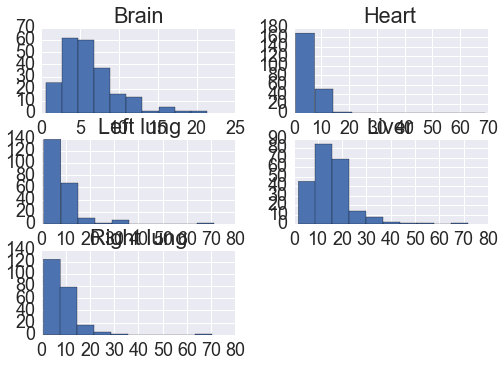

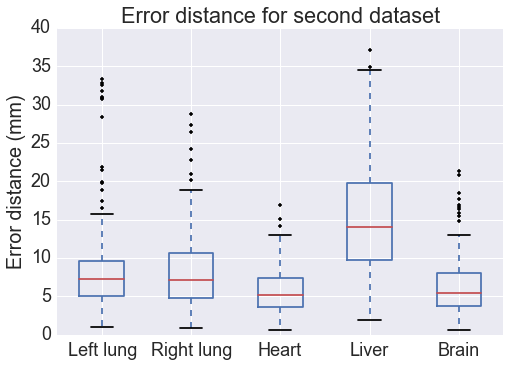

In [9]:
detection_folder = "/vol/vipdata/data/fetal_data/OUTPUT/whole_body_shape_padding50"
ground_truth_folder = "/vol/vipdata/data/fetal_data/motion_correction/landmarks"
data_motion = score_all2(detection_folder, ground_truth_folder,n_jobs=20 )
data_motion[["Left lung","Right lung","Heart","Liver","Brain"]].hist();

plt.figure()
ax = data_motion[["Left lung","Right lung","Heart","Liver","Brain"]].boxplot(return_type='axes',
                                                                      flierprops={'marker':'.','color':[0,0,0]},
                                                                      fontsize=18);
ax.set_ylim([0,40])
ax.yaxis.set_ticks(np.arange(0, 41, 5))
ax.set_ylabel("Error distance (mm)")
ax.set_title('Error distance for second dataset');
plt.savefig("real_case_scenario.pdf", bbox_inches="tight");

print "how many times the detected heart is within 10mm of the true heart?"
print float(np.sum(data_motion['Heart'] <= 10))/len(data_motion.index)

print "how many times the error for the lungs is less than 15mm"
print float(np.sum(np.logical_and(data_motion['Left lung'] <= 15,
                            data_motion['Right lung'] <= 15)))/len(data_motion.index)

print "how many times the error for the liver is less than 20mm"
print float(np.sum(data_motion['Liver'] <= 20))/len(data_motion.index)

All in                                                       91
Heart                                                       185
Left lung                                                   175
Liver                                                       151
Right lung                                                  187
patient_id    1130_11130_21130_31130_41142_61347_11347_21347...
dtype: object
Motion subjects
Left lung [ 49 175] [ 21.875  78.125]
Right lung [ 37 187] [ 16.51785714  83.48214286]
Heart [ 39 185] [ 17.41071429  82.58928571]
Liver [ 73 151] [ 32.58928571  67.41071429]


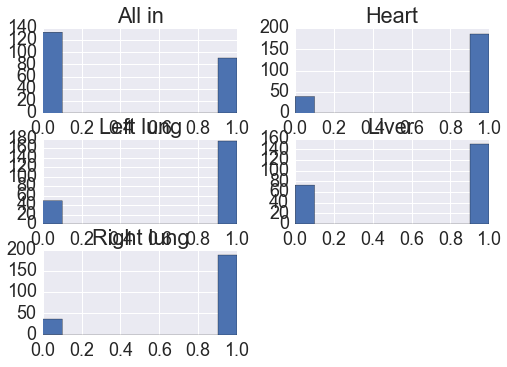

In [19]:
detection_folder = "/vol/vipdata/data/fetal_data/OUTPUT/whole_body_shape_padding50"
ground_truth_folder = "/vol/vipdata/data/fetal_data/motion_correction/landmarks"
data_motion_ellipsoid = count_inside_ellipsoid_motion(detection_folder,
                                            ground_truth_folder,
                                            n_jobs=-1, 
                                            padding=10, 
                                            debug=False )

plt.rc('text', usetex=False)
data_motion_ellipsoid.hist();
print data_motion_ellipsoid.sum()

print "Motion subjects"
for cl in ["Left lung","Right lung","Heart","Liver"]:
    binning = np.bincount(data_motion_ellipsoid[cl].astype('int32'),minlength=2)
    print cl, binning, binning.astype('float') / len(data_motion_ellipsoid.index) * 100

In [20]:
ga_file = "/vol/vipdata/data/fetal_data/motion_correction/ga.tsv"

all_ga = {}
reader = csv.reader( open( ga_file, "rb"), delimiter=" " )
for patient_id, ga in reader:
    all_ga[patient_id] = float(ga)
    
def get_BPD( ga ):
    """50th centile from Snijders"""
    p = np.poly1d( [ -3.20651640e-03,
                     2.14380813e-01,
                     -1.47907551e+00,
                     1.87142471e+01 ] )
    return p(ga)

all_bpd = []
for file_id in data_motion['patient_id']:
    patient_id = file_id.split('_')[0]
    all_bpd.append( get_BPD( all_ga[patient_id] ) )
    
all_bpd = np.array( all_bpd )

print data_motion[data_motion['Brain']==data_motion['Brain'].max()]
print np.sum( data_motion['Brain'] < all_bpd/4 )

       Brain      Heart  Left lung      Liver  Right lung  liver_z patient_id
26  21.31236  12.641595   7.668997  19.077965   11.629948       15     1953_2
224


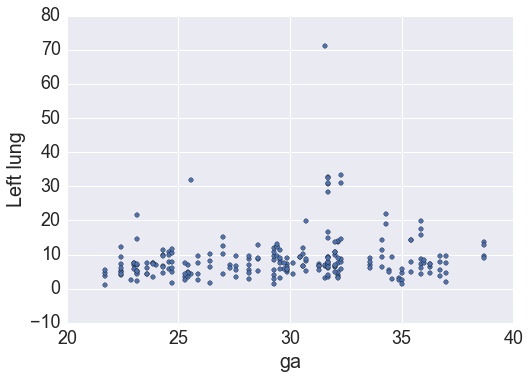

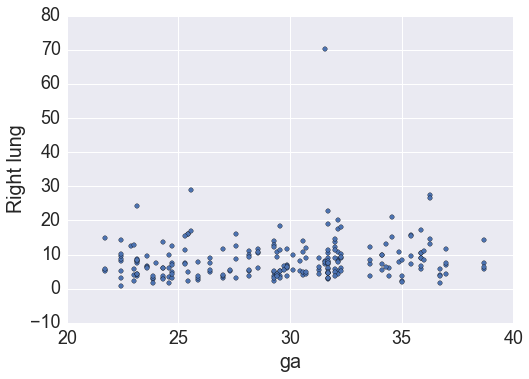

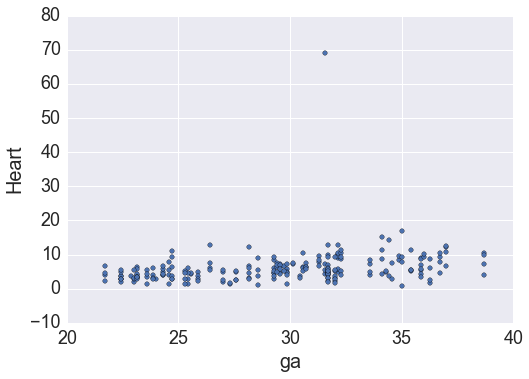

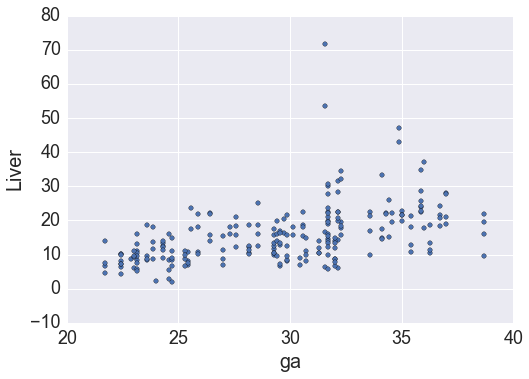

In [30]:
for col in ['Left lung','Right lung','Heart','Liver']:
    plt.figure()
    data_motion.plot(x='ga',y=col,kind='scatter');

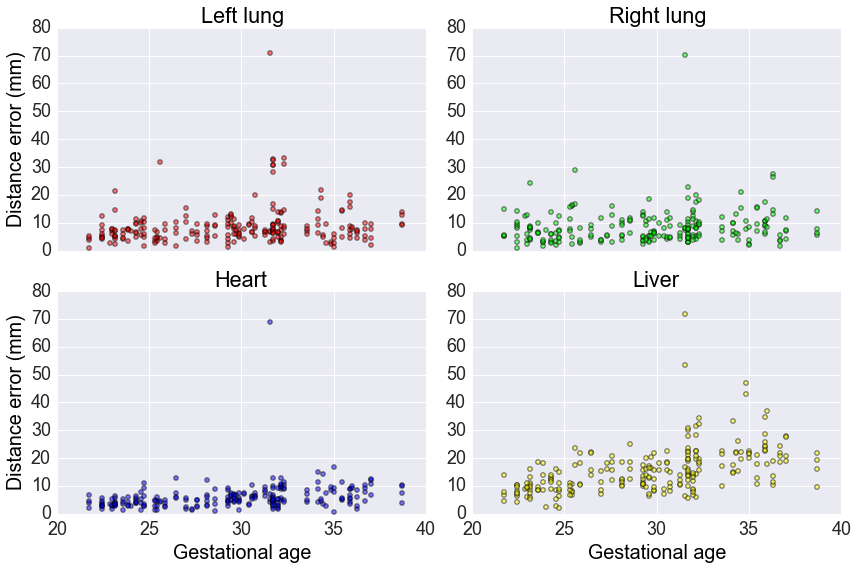

In [17]:
import cPickle as pk

pk.dump(data_motion,open('data_motion.pk', 'wb'))

#plt.rc('text', usetex=True, color='black')
#plt.rc('font', family='serif')

fig = plt.figure(figsize=(12, 8))
gs = matplotlib.gridspec.GridSpec(2, 2) #, width_ratios=[1,0.75,1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3], sharey=ax3)
   
data_motion.plot(x='ga',y='Left lung',kind='scatter',ax=ax1, color=np.array([255, 0, 0])/255,marker='o',edgecolor='black',linewidth=1.2,alpha=.5);
data_motion.plot(x='ga',y='Right lung',kind='scatter',ax=ax2, color=np.array([0, 255, 63])/255,marker='o',edgecolor='black',linewidth=1.2,alpha=.5);
data_motion.plot(x='ga',y='Heart',kind='scatter',ax=ax3, color=np.array([0, 0, 255])/255,marker='o',edgecolor='black',linewidth=1.2,alpha=.5);
data_motion.plot(x='ga',y='Liver',kind='scatter',ax=ax4, color=np.array([255, 255, 0])/255,marker='o',edgecolor='black',linewidth=1.2,alpha=.5);

ax1.set_ylim(0,80)
ax2.set_ylim(0,80)
ax3.set_ylim(0,80)
ax4.set_ylim(0,80)

obj = ax1.set_title('Left lung')
plt.setp(obj, color='black')
obj = ax2.set_title('Right lung')
plt.setp(obj, color='black')
obj = ax3.set_title('Heart')
plt.setp(obj, color='black')
obj = ax4.set_title('Liver')
plt.setp(obj, color='black')

obj = ax1.set_ylabel('Distance error (mm)')
plt.setp(obj, color='black')
obj = ax3.set_ylabel('Distance error (mm)')
plt.setp(obj, color='black')
obj = ax2.set_ylabel('')
obj = ax4.set_ylabel('')

obj = ax3.set_xlabel('Gestational age')
plt.setp(obj, color='black')
obj = ax4.set_xlabel('Gestational age')
plt.setp(obj, color='black')

fig.tight_layout()

#plt.savefig("detection_by_ga.pdf", bbox_inches="tight")

Combined plot
-------------

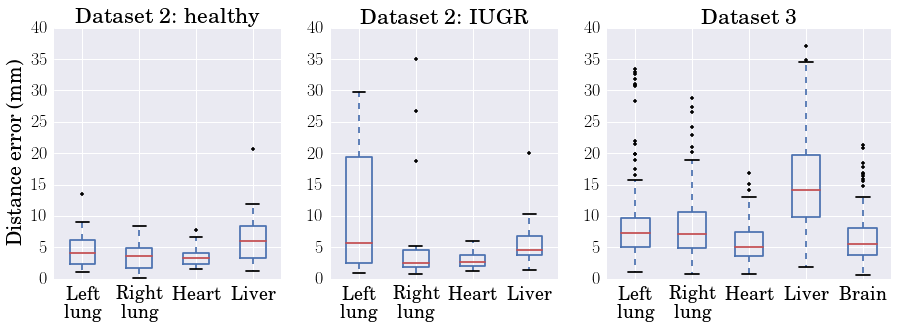

In [10]:
plt.rc('text', usetex=True, color='black')
plt.rc('font', family='serif')

fig = plt.figure(figsize=(15, 4.5))
gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[0.8,0.8,1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[2], sharey=ax1)

label_names = ["Left\nlung","Right\nlung","Heart","Liver"]

## Healthy
data_leaveoneout[data_leaveoneout['IUGR']==0][["Left lung","Right lung","Heart","Liver"]].boxplot(return_type='axes',
                                                                               flierprops={'marker':'.','color':[0,0,0]},
                                                                               fontsize=18,
                                                                               ax=ax1);

ax1.set_ylim([0,40])
ax1.yaxis.set_ticks(np.arange(0, 41, 5))
obj = ax1.set_ylabel("Distance error (mm)")
plt.setp(obj, color='black')
#obj = ax1.set_title(r'1\textsuperscript{st} dataset: healthy');
obj = ax1.set_title(r'Dataset 2: healthy');
plt.setp(obj, color='black')
obj = ax1.set_xticklabels(label_names)
plt.setp(obj, color='black')

axes_obj = plt.getp(ax1,'axes')                 #get the axes' property handler
ytl_obj = plt.getp(axes_obj, 'yticklabels')     #get the properties for 
                                                #  yticklabels
plt.setp(ytl_obj, color='black')

## IUGR
data_leaveoneout[data_leaveoneout['IUGR']==1][["Left lung","Right lung","Heart","Liver"]].boxplot(return_type='axes',
                                                                               flierprops={'marker':'.','color':[0,0,0]},
                                                                               fontsize=18,
                                                                               ax=ax2);
#obj = ax2.set_title(r'1\textsuperscript{st} dataset: IUGR');
obj = ax2.set_title(r'Dataset 2: IUGR');
plt.setp(obj, color='black')
obj = ax2.set_xticklabels(label_names)
plt.setp(obj, color='black')

axes_obj = plt.getp(ax2,'axes')                 #get the axes' property handler
ytl_obj = plt.getp(axes_obj, 'yticklabels')     #get the properties for 
                                                #  yticklabels
plt.setp(ytl_obj, color='black')

## Motion artefacts
data_motion[["Left lung","Right lung","Heart","Liver","Brain"]].boxplot(return_type='axes',
                                                                      flierprops={'marker':'.','color':[0,0,0]},
                                                                      fontsize=18,
                                                                      ax=ax3);
#obj = ax3.set_title(r'2\textsuperscript{nd} dataset');
obj = ax3.set_title(r'Dataset 3');
plt.setp(obj, color='black')
obj = ax3.set_xticklabels(label_names+['Brain'])
plt.setp(obj, color='black')

axes_obj = plt.getp(ax3,'axes')                 #get the axes' property handler
ytl_obj = plt.getp(axes_obj, 'yticklabels')     #get the properties for 
                                                #  yticklabels
plt.setp(ytl_obj, color='black')

plt.savefig("combined_plot2.pdf", bbox_inches="tight");

In [8]:
data_motion[data_motion['Heart']>60]

,Brain,Heart,Left lung,Liver,Right lung,ga,liver_z,patient_id
9,6.519831,68.993696,71.058792,71.700885,70.251155,31.57,14,1351_1


In [9]:
len(data_motion)

224